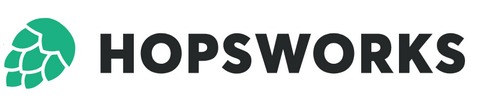

# Data Validation using Hopsworks integration with Great Expectations 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/integrations/great_expectations/fraud_batch_data_validation.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

The purpose of this notebook is to showcase how **Hopsworks Feature Store** integrates seamlessly with **Great Expectations (GE) library** to perform data validation. Simply define an expectation suite in GE and attach it to a Feature Group. Hopsworks will automatically run validation on insert and centralize your expectation suite as well as validation reports. In addition, you can check the validation history directly in the Feature Group UI page.




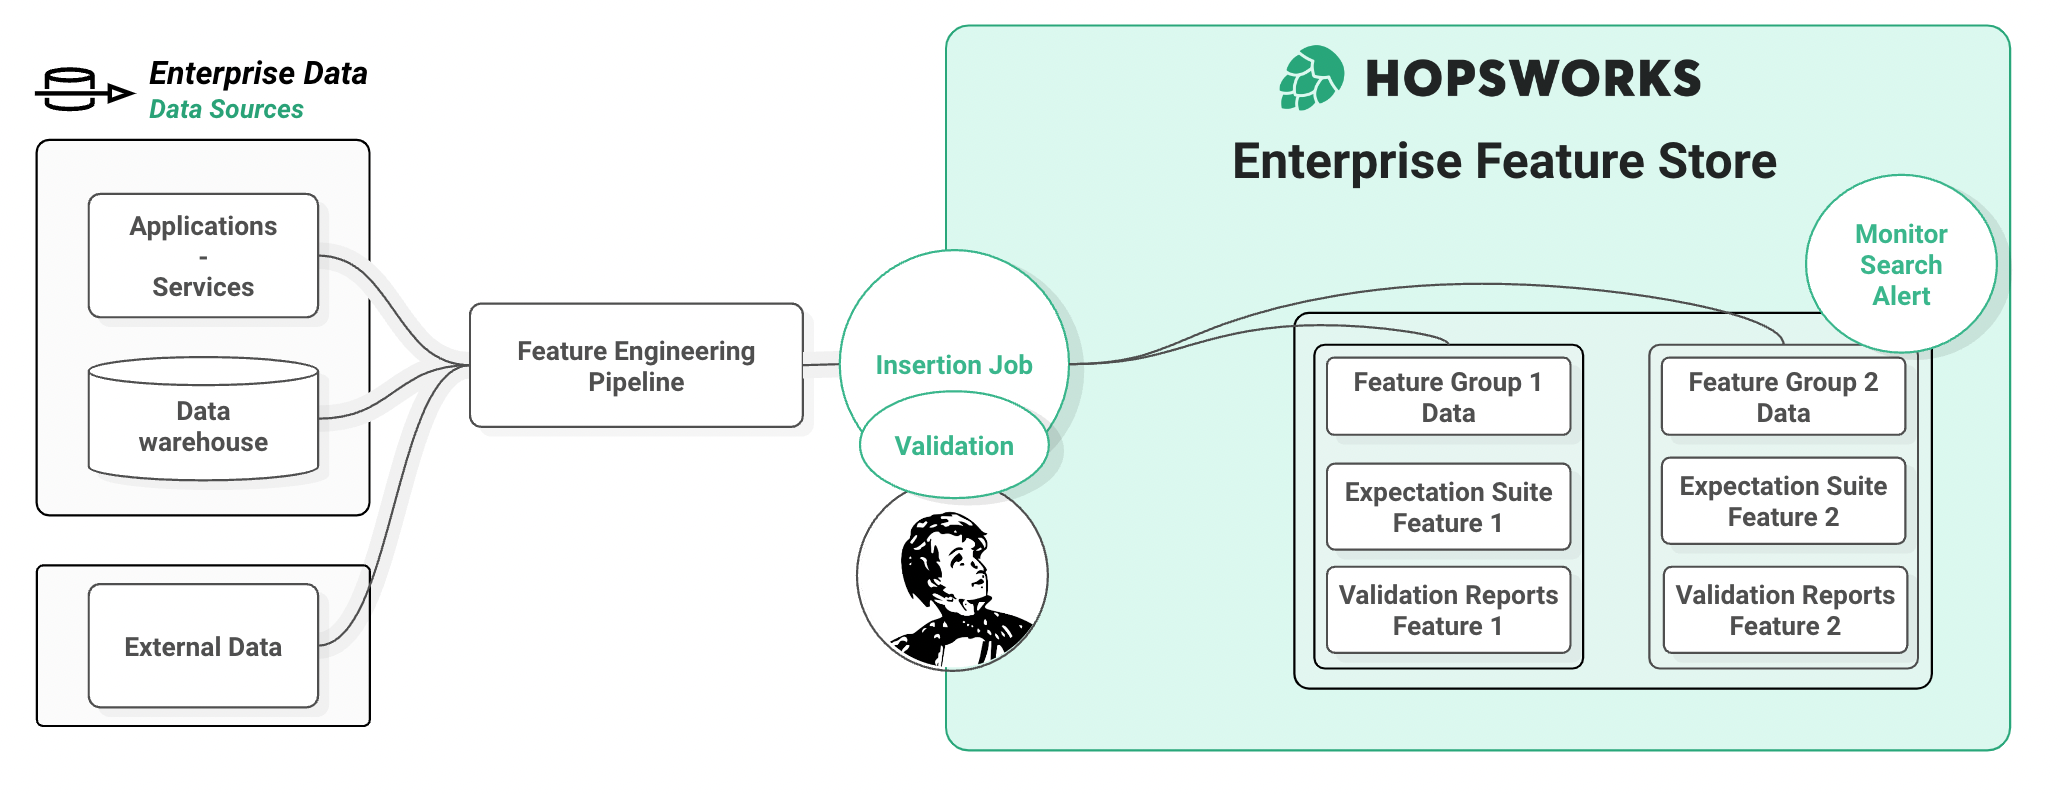


Check the step 1 in the fraud batch tutorial to learn more about Feature Group : 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_batch/1_feature_groups.ipynb)


## 🗒️ This notebook is divided in 5 sections:
1. Loading the data and minimal feature engineering,
2. Connect to Hopsworks and create a Feature Group,
3. Define Data Validation Step using Great Expectations,
4. Setup Automatic Validation on Insert and upload a DataFrame,
5. Monitor Validation Report in Hopsworks UI.

Appendix:
- Maintain your Data Validation Pipeline : Edit an Expectation Suite


First of all we will load the data and do some feature engineering on it.

In [ ]:
!pip install -U hopsworks --quiet

## <span style="color:#ff5f27;"> 💽 1. Loading the Data & Minimal Feature Engineering</span>

The data we will use comes from two different CSV files:

- `transactions.csv`: transaction information such as timestamp, location, and the amount. Importantly, the binary `fraud_label` variable tells us whether a transaction was fraudulent or not.
- `profiles.csv`: credit card user information such as birthdate and city of residence.

We can conceptualize these CSV files as originating from separate data sources.
**Both files have a credit card number column `cc_num` in common, which we can use for joins.**

Let's go ahead and load the data.

In [ ]:
import pandas as pd
trans_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/transactions.csv", parse_dates=["datetime"])
trans_df.head(3)
profiles_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/profiles.csv", parse_dates=["birthdate"])
profiles_df.head(3)



This could for instance be the age of a customer at the time of a transaction, which combines the `birthdate` feature from `profiles.csv` with the `datetime` feature from `transactions.csv`.


In [ ]:
import numpy as np

# Compute age at transaction.
age_df = trans_df.merge(profiles_df, on="cc_num", how="left")
trans_df["age_at_transaction"] = (age_df["datetime"] - age_df["birthdate"]) / np.timedelta64(1, "Y")

# Convert date time object to unix epoch in milliseconds
trans_df.datetime = trans_df.datetime.values.astype(np.int64) // 10 ** 6

## <span style="color:#ff5f27;"> 🪄 2. Connect to Hopsworks & create a Feature Group </span>

A [feature group](https://docs.hopsworks.ai/feature-store-api/latest/generated/feature_group/) can be seen as a collection of conceptually related features. In our case, we will create a feature group for the transaction data. It will have `cc_num` as primary key.

Before we can create a feature group we need to connect to our feature store.

In [ ]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

To create a feature group we need to give it a name and specify a primary key. It is also good to provide a description of the contents of the feature group and a version number, if it is not defined it will automatically be incremented to `1`.

In [ ]:
trans_fg = fs.get_or_create_feature_group(
    name="ge_transactions_fg",
    version=1,
    description="Transaction data",
    primary_key=['cc_num'],
    event_time='datetime'
)

A full list of arguments can be found in the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/feature_store_api/#create_feature_group).

At this point, we have only specified some metadata for the feature group. It does not store any data or even have a schema defined for the data. To make the feature group persistent we populate it with its associated data using the `insert` function. We are inserting a single row here.

In [ ]:
job, _ = trans_fg.insert(trans_df.head(1), write_options={"wait_for_job": False})

At the creation of the feature group, you will prompted with an URL that will directly link to it; there you will be able to explore some of the aspects of your newly created feature group.

[//]: <> (insert GIF here)

## <span style="color:#ff5f27;"> 🗄 3. Define Data Validation Step using Great Expectations </span>

An Expectation Suite in Great Expectations contains multiple expectations which will be evaluated against a DataFrame on validation. This step will generate a report gathering information on whether the DataFrame fulfills those expectations. Setup the validation pipeline using the usual GE object and syntax. Once your expectation suite is ready, register it with the Hopsworks backend.

In [ ]:
import great_expectations as ge
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

### Exploring and Defining an Expectation Suite

When prototyping an expectation suite you can use the Great Expectations DataFrame wrapper to evaluate expectations directly and enable auto-complete.

In [ ]:
ge_trans_df = ge.from_pandas(trans_df)

# Check if trans_df is sorted according to datetime
validation_result = ge_trans_df.expect_column_values_to_be_increasing(
    column="datetime",
    strictly=False
)

print(validation_result)

Note that this does not append the expectation to the suite, however the result contains all the necessary information to recreate the expectation. 

In [ ]:
expectation_suite_trans = ge_trans_df.get_expectation_suite()
expectation_suite_trans.expectation_suite_name = "transaction_suite"
print(expectation_suite_trans)

In [ ]:
expectation_suite_trans.add_expectation(validation_result["expectation_config"])
print(expectation_suite_trans)

You can populate the suite with various expectation configurations. Many standard expectations are implemented in Great Expectations, from computing the mean of a column to counting the number of null values for example.

In [ ]:
# Check for errors which could lead to technical issues

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_unique",
        kwargs={"column":"tid", "result_format":"COMPLETE"}
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_in_set",
        kwargs={
            "column":"fraud_label",
            "value_set": [0,1]
        }
    )
)

# Assess data correctness

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"amount",
            "min_value": 0
        }
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column":"age_at_transaction",
            "min_value": 17,
            "max_value": 130
        }
    )
)

# Or simply to monitor data statistics and quality, e.g number of null values

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
      expectation_type="expect_column_mean_to_be_between",
      kwargs={"column":"age_at_transaction", "min_value": 55, "max_value": 70}
    )
)

expectation_suite_trans.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column":"category"}
    )
)


In [ ]:
ge_trans_df = ge.from_pandas(trans_df, expectation_suite=expectation_suite_trans)

validation_report_trans = ge_trans_df.validate()

### Generate an Expectation Suite from your data using Great Expectations Profiler

For complex DataFrames, Great Expectations offers a profiler which generates a basic expectation suite tailored to your data. You can then use this suite as you would any other expectation suite with Hopsworks.

In [ ]:
# ignore deprecation warnings
expectation_suite_profiled, validation_report = ge_trans_df.profile(profiler=ge.profile.BasicSuiteBuilderProfiler)

print(f"The suite contains {len(expectation_suite_profiled['expectations'])} expectations for {len(trans_df.columns.values)} columns. See sample below\n" + ge_trans_df.get_expectation_suite().__repr__()[:455])

Note that you cannot register the report generated by the profiler as the suite was not registered with Hopsworks before the validation was run.

## <span style="color:#ff5f27;"> ✅ 4.Setup Automatic Validation On Insert and upload a DataFrame </span>

Register the expectation suite corresponding to a Feature Group with the backend

In [ ]:
# The "ALWAYS" ingestion policy inserts data even when validation fails, 
# ideal to avoid data loss and rapid prototyping
trans_fg.save_expectation_suite(expectation_suite_trans, validation_ingestion_policy="ALWAYS")

Once the suite is registered in the backend, data validation will run on every insert without additional boilerplate. The suite is retrieved from the backend, used to validate the DataFrame and the resulting validation report uploaded. Depending on the ingestion policy and validation success, data are subsequently inserted in the Feature Group. The example below illustrate the "ALWAYS" use case where insertion is performed despite a validation failure.

In [ ]:
trans_job, trans_report = trans_fg.insert(trans_df)

You can delete the Expectation Suite, the reports will be preserved until Feature Group deletion.

In [ ]:
trans_fg.delete_expectation_suite()

The "STRICTLY" ingestion policy aborts insertion job if the validation fails. However it still uploads the report to Hopsworks so you can check the UI to understand what went wrong and have a record of your attempt.

In [ ]:
# The "STRICT" ingestion policy only inserts data when data validation succeeds,
# perfect for production environment 
trans_fg.save_expectation_suite(expectation_suite_trans, validation_ingestion_policy="STRICT")

trans_job, trans_report = trans_fg.insert(trans_df)
print(f"Job is empty as insertion was aborted: {trans_job}")

In [ ]:
# Find the culprit (easier done through the UI)
culprit = [result for result in trans_report.results if result.success is False][0]
print(f"culprit is expectation {culprit.expectation_config['meta']['expectationId']}, with type {culprit.expectation_config['expectation_type']} applied to column {culprit.expectation_config['kwargs']['column']}")

In [ ]:
# We need to sort the datetime column to fix it
trans_df.sort_values(by=["datetime"], inplace=True)

trans_job, trans_report = trans_fg.insert(trans_df)
print(f"insertion is approved: {trans_job}")

## <span style="color:#ff5f27;"> 📺 5. Monitor Validation Reports in Hopsworks UI </span>

Follow the links to explore a summary of the validation reports generated by Great Expectations directly in the Feature Group page!

Despite some expectations in the validation step raising exception or failing, you can see that the trans DataFrame has been inserted in the Feature Group. In the validation results tab, you can see one expectation fail was caused by an unexpected young customer making a transaction. You can download the full report to investigate errors like exception or more complex results.


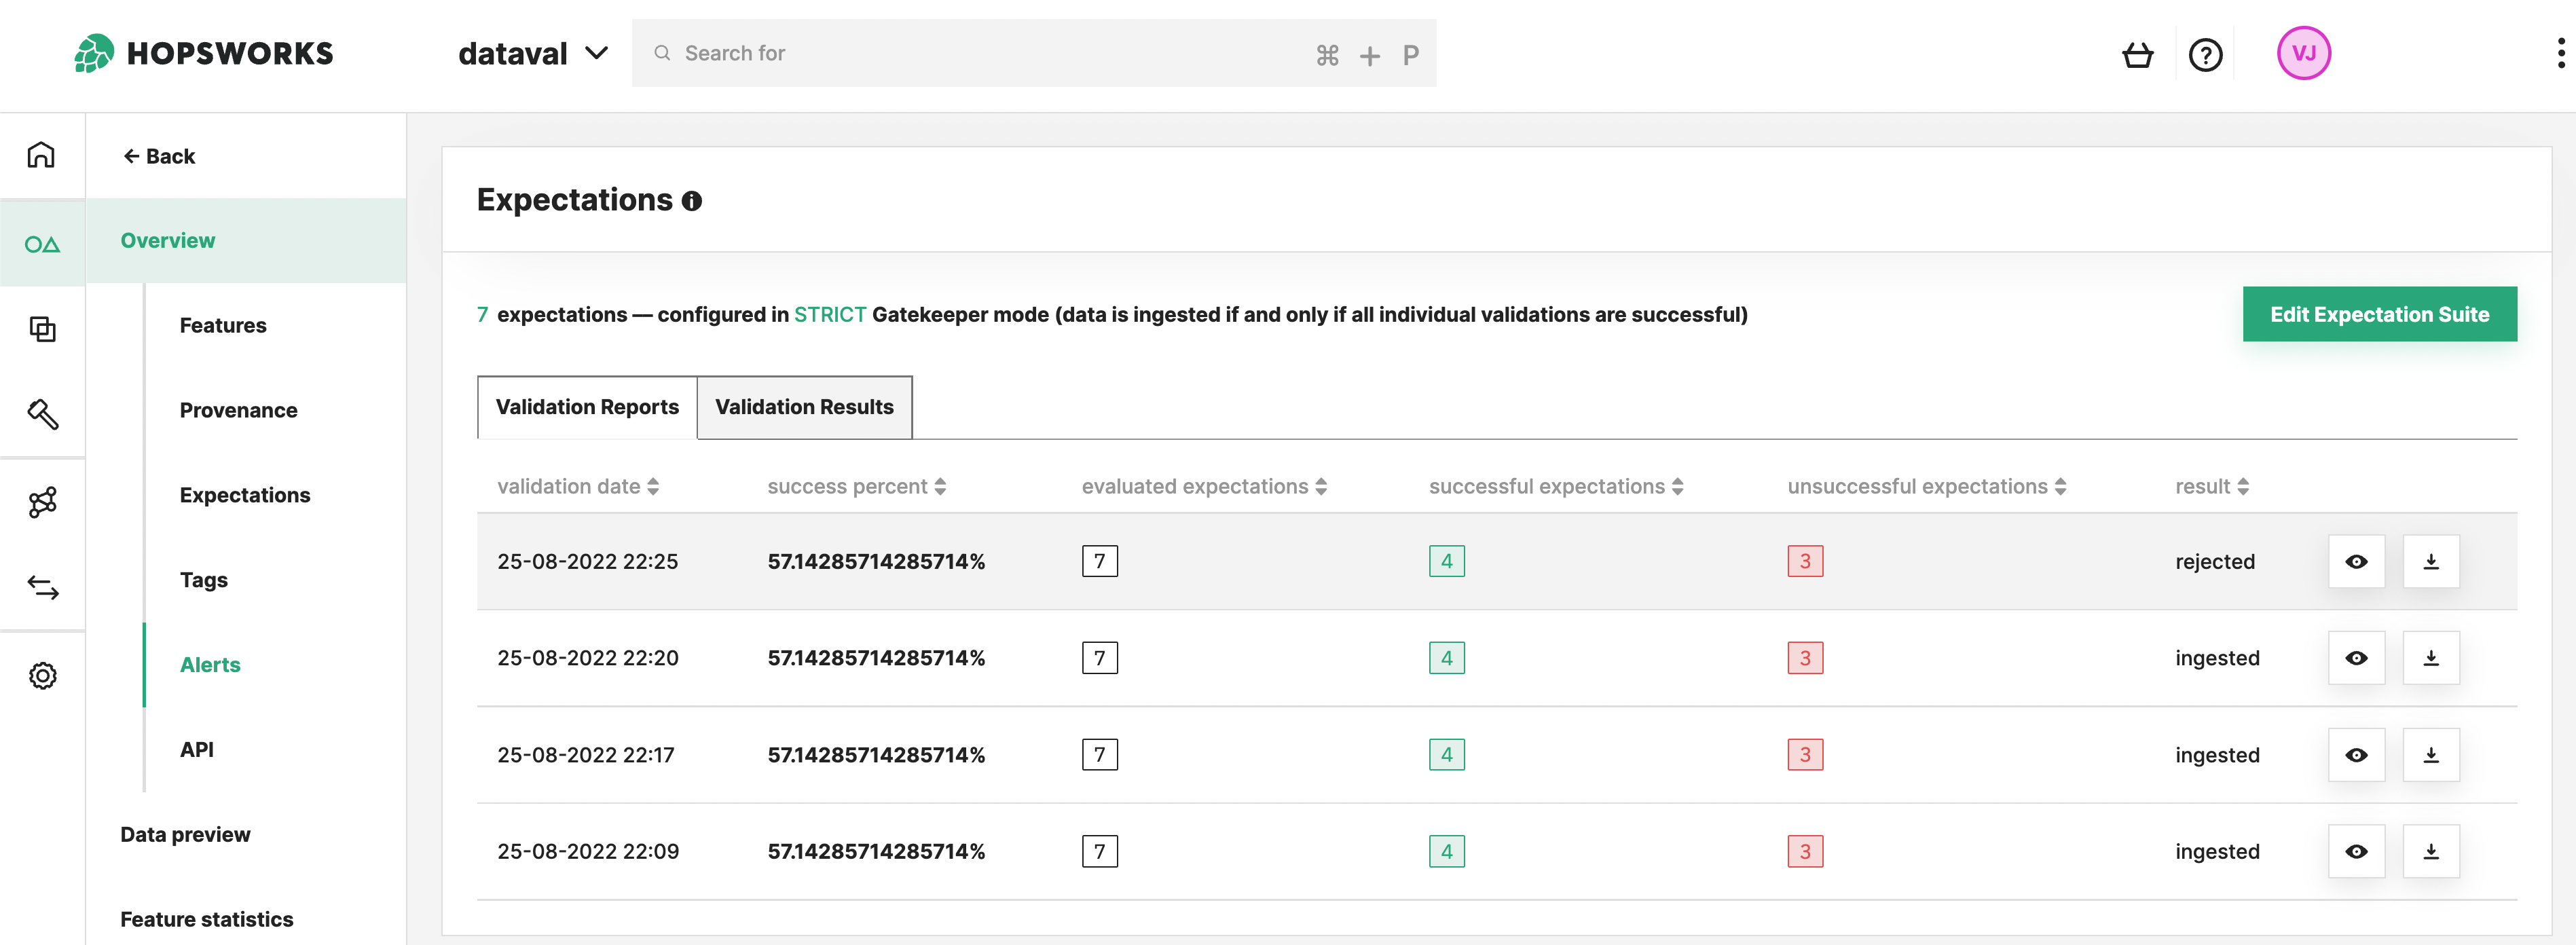

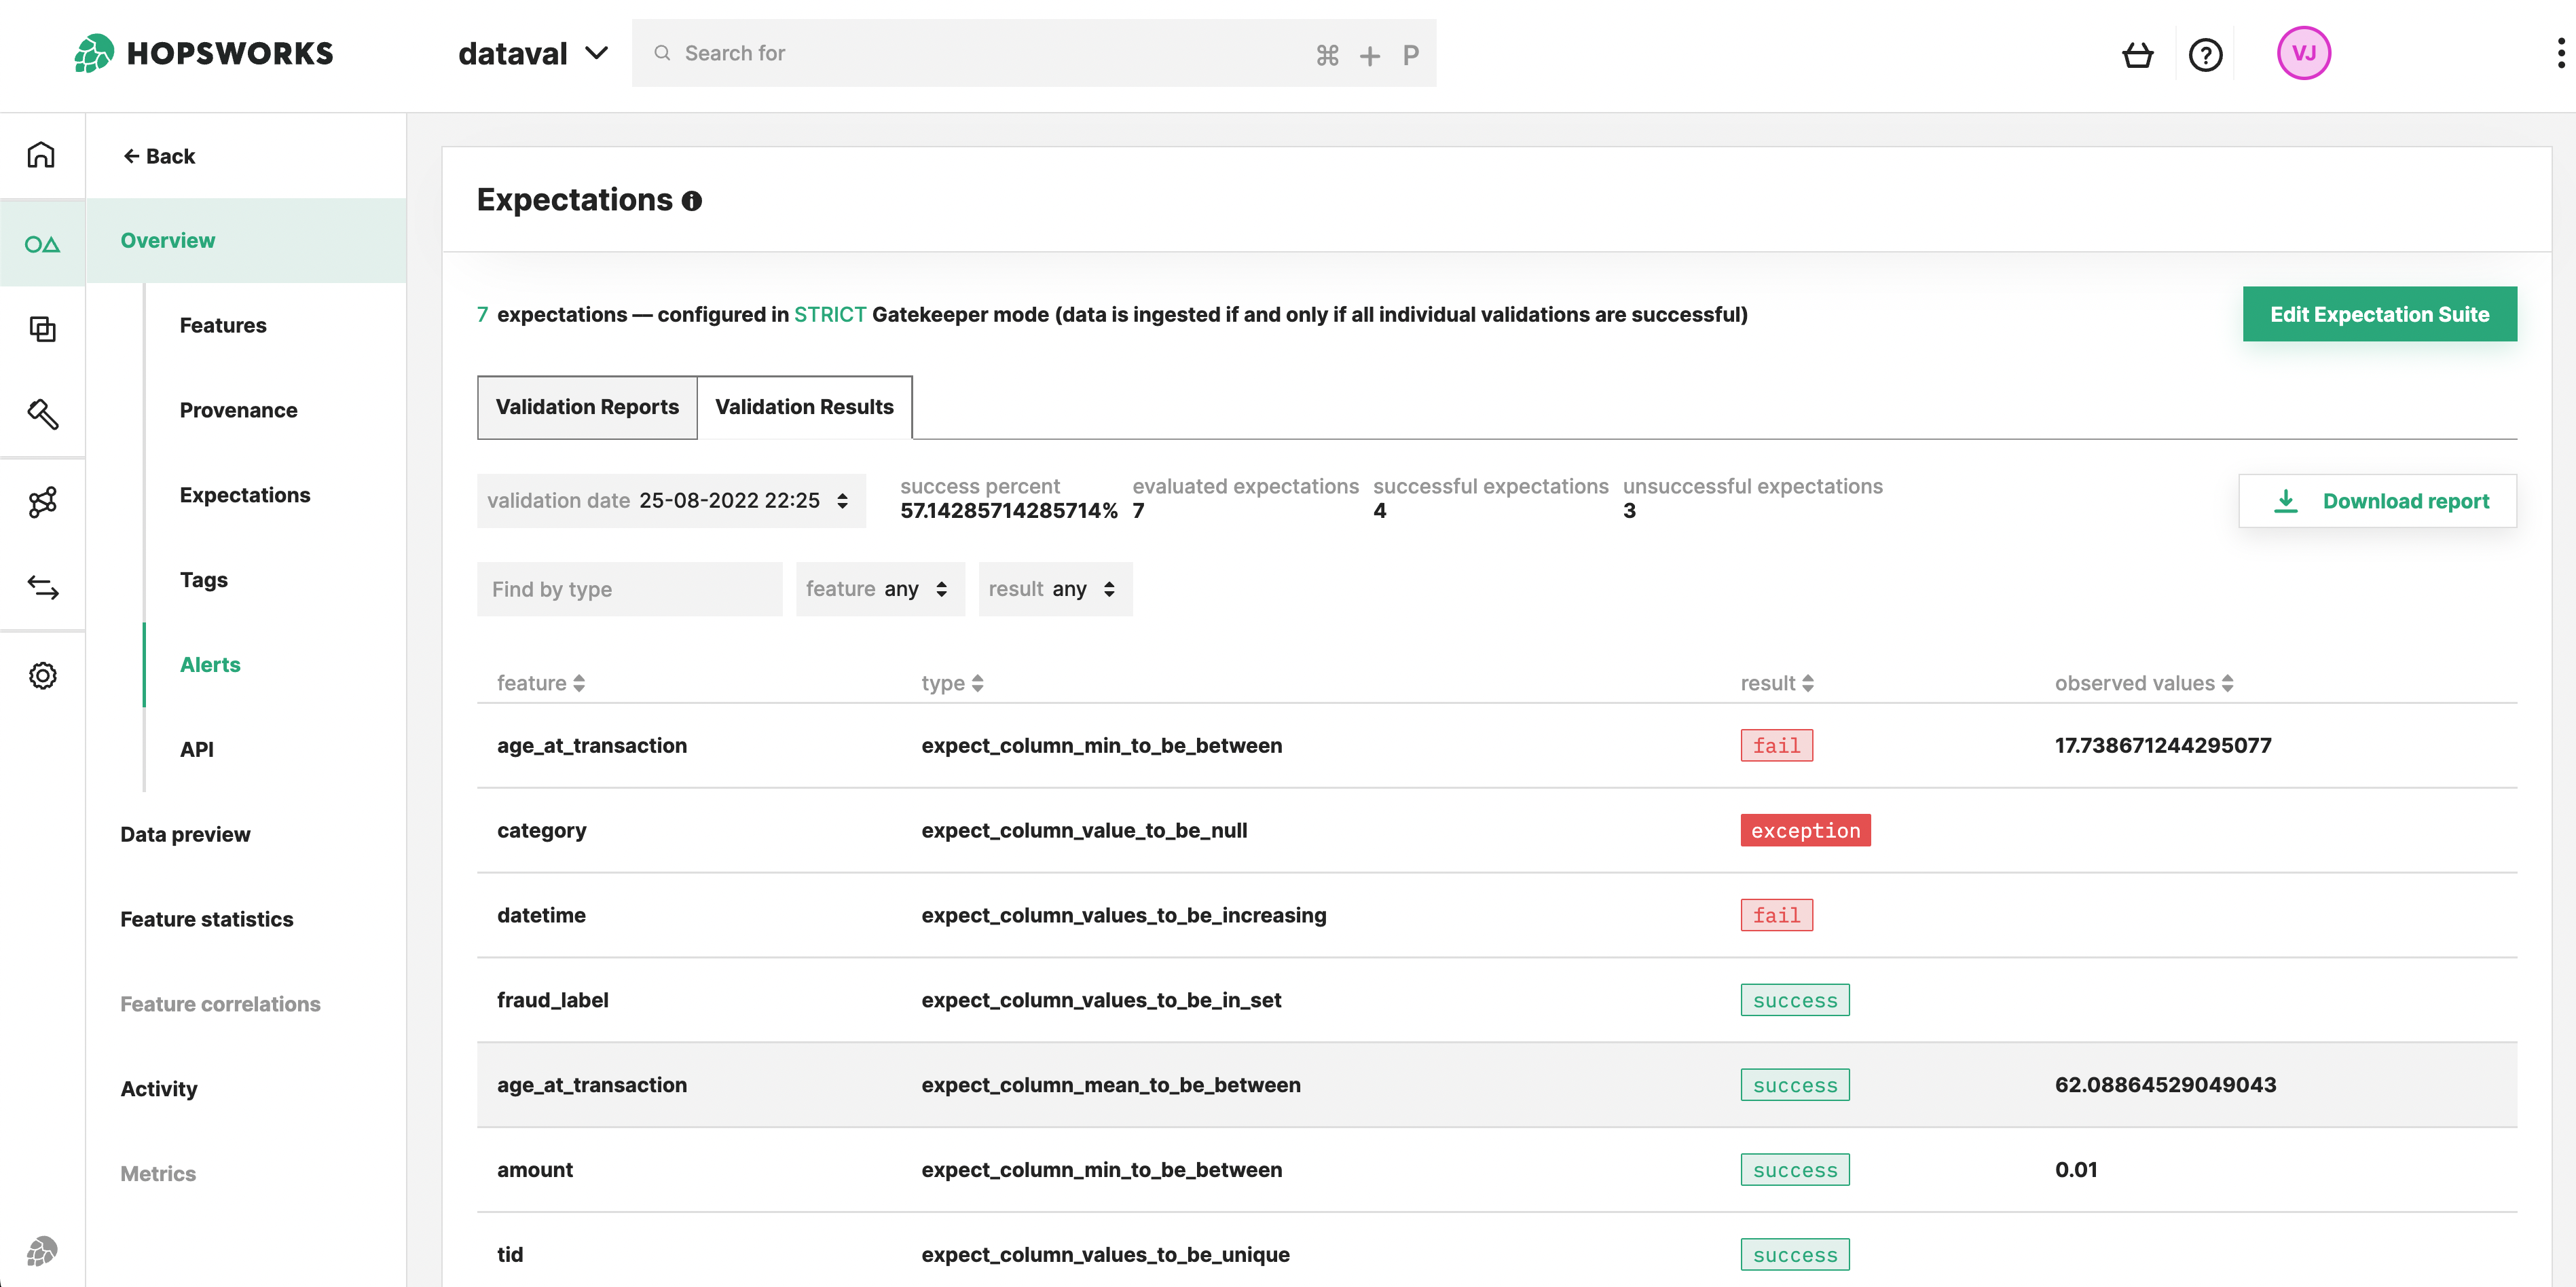

You can also retrieve validation report summaries via the python client.

In [ ]:
trans_all_validation_report_summaries = trans_fg.get_all_validation_reports()


You are however more likely to be in one of two use cases: 
- Check the latest validation report because something went horribly wrong and you have been tasked with sorting it out.
- Check the history for a particular Expectation to understands exactly when things started to go horribly wrong.

Luckily Hopsworks provide convenience methods for both cases 🙂

In [ ]:
last_trans_summary = trans_fg.get_latest_validation_report()

In [ ]:
# Create a quick history
from time import sleep
from datetime import datetime

start_time = datetime.now()

for i in range(0, 10):
  job, report = trans_fg.insert(trans_df[i*10:(i+1)*10], write_options={"wait_for_job": False})
  sleep(1) # Force sleep to avoid uploading report with same timestamp

# Get the history of the mean of column age_at_transaction
mean_expectation_id = next(x.meta["expectationId"] for x in trans_fg.expectation_suite.expectations if x.expectation_type == "expect_column_mean_to_be_between")

validation_history = trans_fg.get_validation_history(expectation_id=mean_expectation_id, start_validation_time=start_time) 

In [ ]:
# Turn it into a pandas DataFrame
mean_age_at_transaction = pd.DataFrame({"validation_time": pd.to_datetime([x.meta["validationTime"] for x in validation_history]),
                                        "observed_value": [x.result["observed_value"] for x in validation_history],
                                        "ingestion_result": ["green" if x.meta["ingestionResult"] == "INGESTED" else "red" for x in validation_history]})

%matplotlib inline

ax = mean_age_at_transaction.plot("validation_time", "observed_value", kind="line", title="Mean Age at Transaction on Insertion", legend=False, figsize=(12, 8))
mean_age_at_transaction.plot("validation_time", "observed_value", kind="scatter", c=mean_age_at_transaction["ingestion_result"].values, ax=ax)

You can also check out the history directly in the UI. Go to the Feature Group page, scroll to the Expectation section and click on the Validation Result tab. You can see information about individual expectation result in the table for a particular report. If you click on the expectation result you will open a sidebar with a summary of the history of this particular expectation.

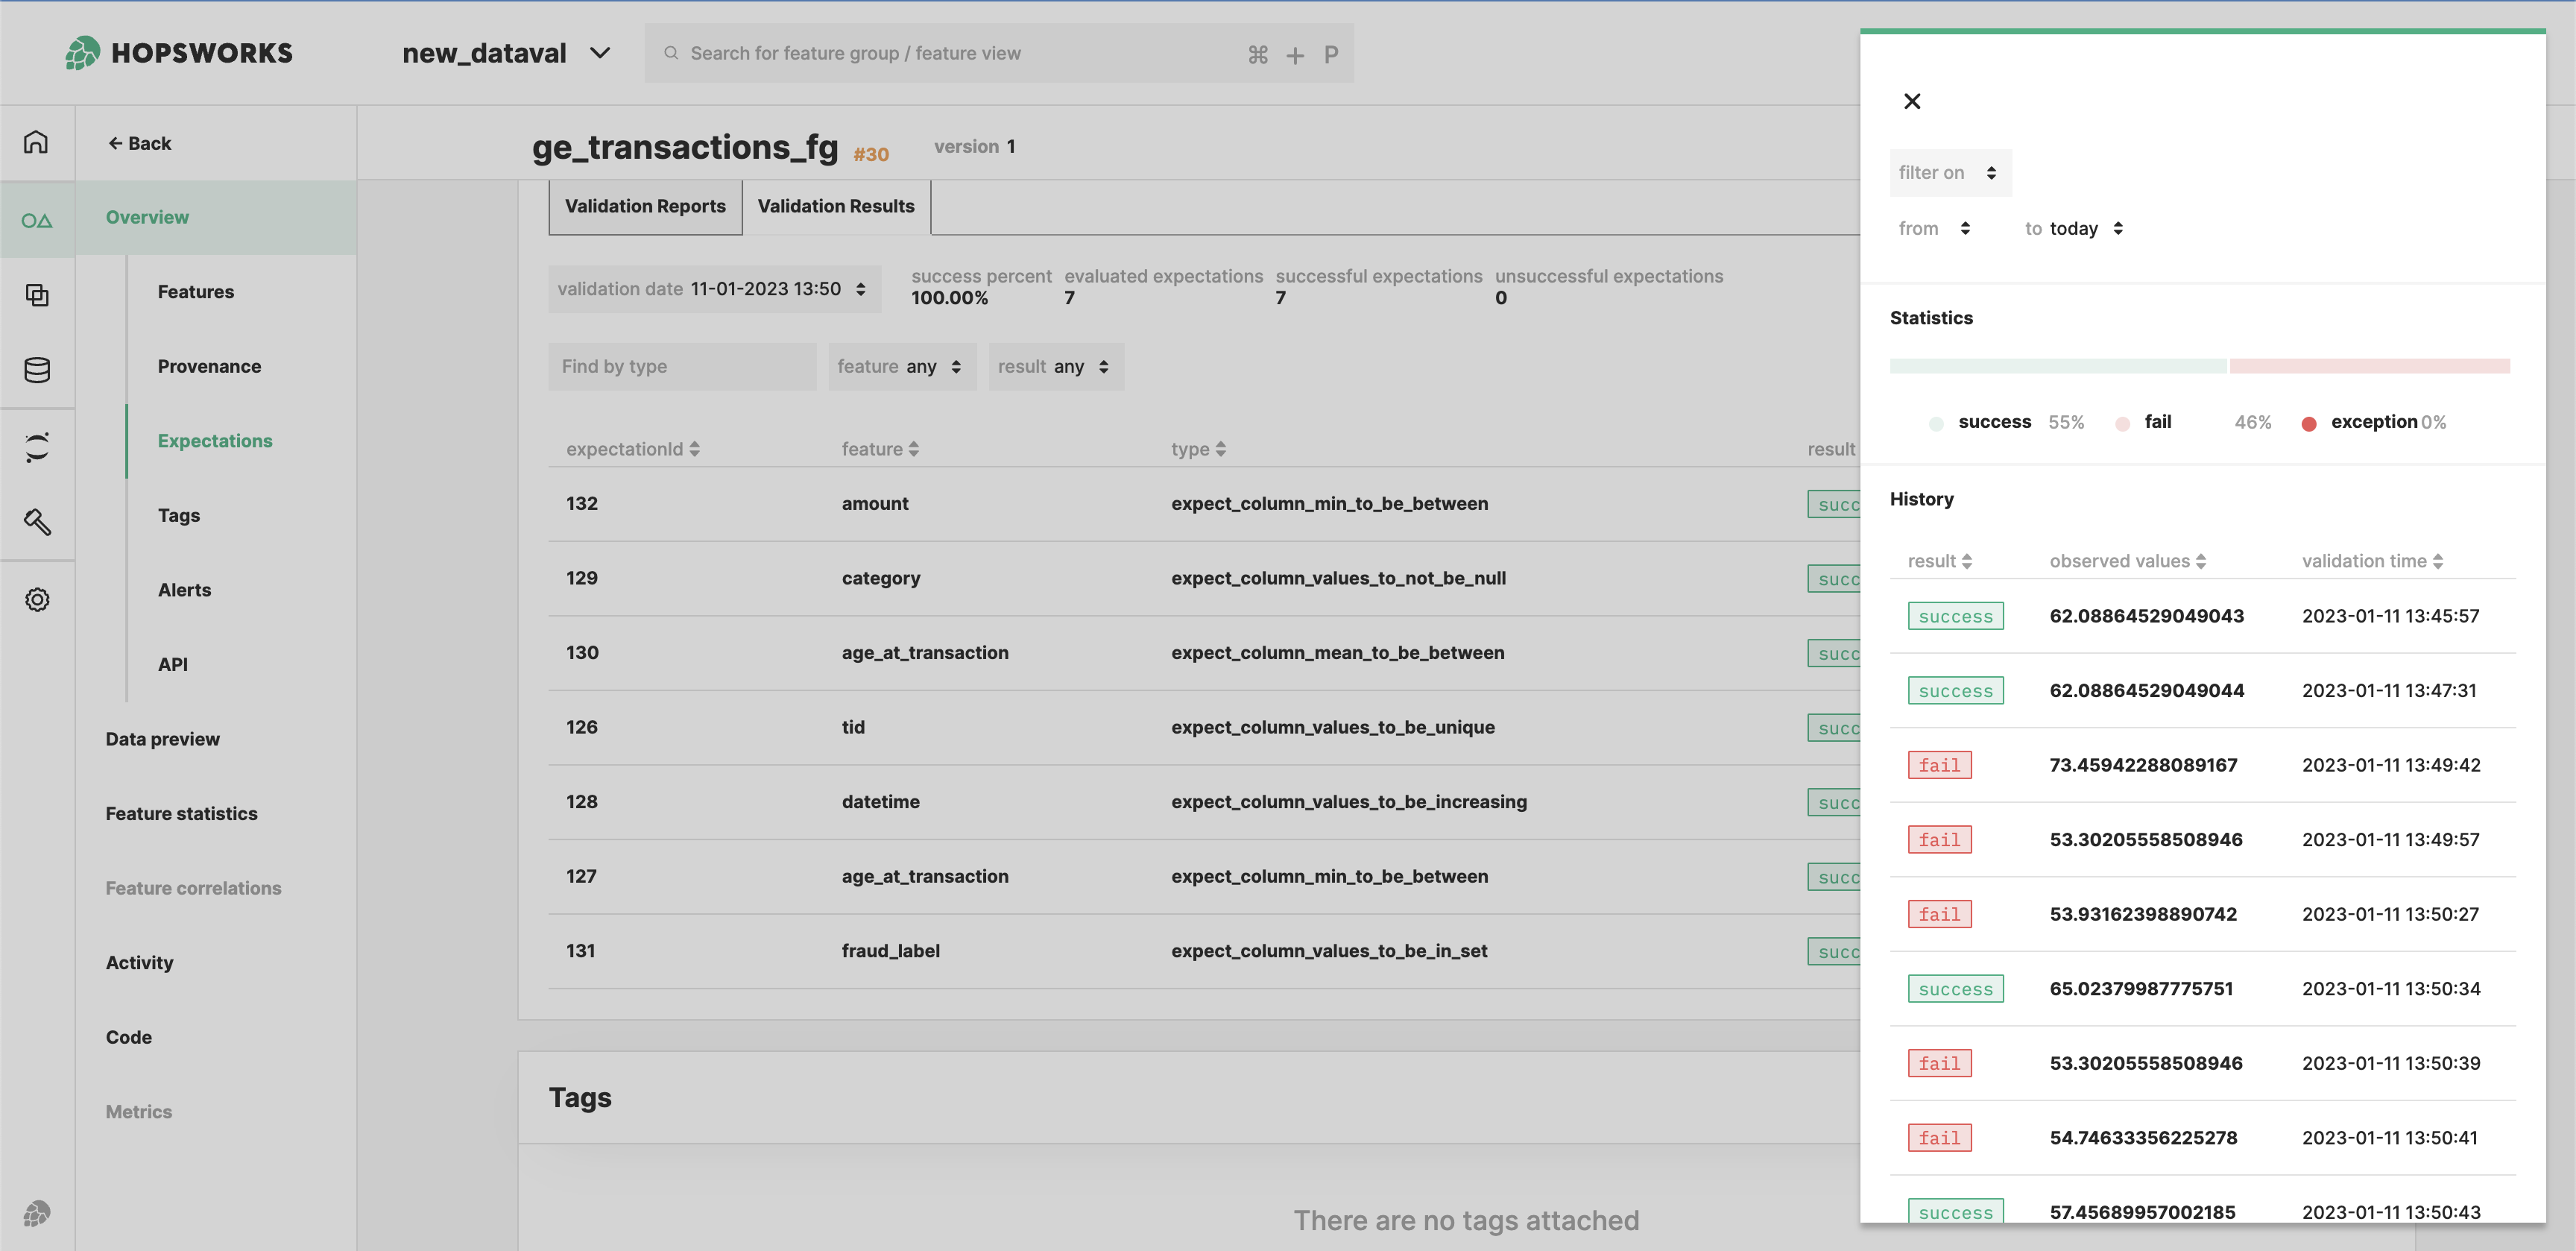

## <span style="color:#ff5f27;"> 🎁 Wrapping things up </span>

In this tutorial, we have defined a Data Validation Suite using Great Expectations and attached to a Feature Group in Hopsworks. This result in automatic validation of every DataFrame inserted in the Feature Group without any extra work. On top of that you can monitor your validation directly on the Feature Group page in Hopsworks UI. This concludes our Data Validation tutorial, check out the next step to apply it to your own data!

## ⚡ Next Step: Use your own data and the Great Expectations profiler to create a data validated Feature Group in Hopsworks

Put your newly acquired skills to the test! Load your own data, use the GE profiler to generate a tailored suite and insert it into hopsworks with just 4 lines of code.

In [ ]:
# Load sample data. Replace it with your own!
my_data_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/card_fraud_data/credit_cards.csv")

# Use Great Expectation profiler (ignore deprecation warning)
expectation_suite_profiled, validation_report = ge.from_pandas(my_data_df).profile(profiler=ge.profile.BasicSuiteBuilderProfiler)

# Create a Feature Group on hopsworks with an expectation suite attached. Don't forget to change the primary key!
my_validated_data_fg = fs.get_or_create_feature_group(name="my_validated_data_fg", version=1, description="My data", primary_key=['cc_num'], expectation_suite=expectation_suite_profiled)

# Insert and validate your data
insert_job, validation_report = my_validated_data_fg.insert(my_data_df)

## 🔧 Maintain your Data Validation Pipeline : Edit your Expectation Suite


As business requirements evolve, part of your validation step might need to be edited. Hopsworks python client emulates Great Expectations API to let you edit individual Expectations of your registered suite. You can also edit in the UI by going to your Feature Group page and clicking edit in the top right corner.


In [ ]:
# Add an expectation to the suite, both locally and in the backend
new_expectation = trans_fg.expectation_suite.add_expectation(
            ExpectationConfiguration(
                expectation_type="expect_column_median_to_be_between",
                kwargs={
                    "column": "amount",
                    "min_value": 0,
                    "max_value": 1000
                }
            )
        )

# If you need to edit an expectation instead
replaced_expectation = trans_fg.expectation_suite.replace_expectation(
            ExpectationConfiguration(
                expectation_type="expect_column_median_to_be_between",
                kwargs={
                    "column": "amount",
                    "min_value": -100,
                    "max_value": -20
                },
                meta= {
                    "expectationId": new_expectation.meta["expectationId"]
                }
            )
        )

# You can get the expectation from the backend to double check change have indeed been persisted
fetched_expectation = trans_fg.expectation_suite.get_expectation(new_expectation.meta["expectationId"])
print(fetched_expectation)

# Delete an expectation that is no longer needed
trans_fg.expectation_suite.remove_expectation(new_expectation.meta["expectationId"])